# Anomaly Detection for Tool Wear Monitoring Using a Disentangled-Variational-Autoencoder

This notebook replicates the results and figures for the end-to-end deep learning experiment in my thesis. The experiments use the UC Berkeley milling data (found on the [NASA Prognostics Data Repository](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/))

The notebook can be run with google colab. Alternatively, clone the repo and run on your local machine. You'll need python 3 with the following packages in your local environment:

* TensorFlow 2.0
* pandas
* sci-kit learn
* SciPy
* Numpy

If you use google colab, and want to run many random searches for the model training, you should enable the GPU.

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

# Setup Notebook

In [1]:
import numpy as np
import scipy.io as sio
from sklearn.utils import shuffle
import pathlib
from pathlib import Path
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random

import h5py
import zipfile

from IPython.display import clear_output, display # clear the output if needed

import tensorflow as tf
from tensorflow import keras
import tensorboard
from tensorflow.keras.models import model_from_json

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc,
)

from scipy.stats import randint as sp_randint
from scipy.stats import uniform
import traceback

%matplotlib inline
# %load_ext autoreload
# %autoreload 2

2025-02-14 14:34:39.292312: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-14 14:34:40.094612: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2025-02-14 14:34:40.094744: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2025-02-14 14:34:40.094753: W tensorflow/compiler/tf2tensorrt/util

Prepare the notebook by downloading the milling data file and other important files. This needs to be done if running in google colab. If the repository has been cloned from github, then there is no need.

In [2]:
cwd = Path.cwd() # current working directory

folder_raw_data = Path('data/raw/') # raw data folder that holds the .zip .mat files for milling data
folder_processed_data = Path('data/processed/') # processed data folder
folder_models = Path('models/') # folder for saved models

In [3]:
# if the the raw data folder does not exist, then you are likely
# in a google colab environment. In that case, we will create the 
# raw data and processed data folders and download the appropriate
# files
if folder_raw_data.exists() == False:

    pathlib.Path(folder_raw_data).mkdir(parents=True, exist_ok=True)
    os.chdir(folder_raw_data)
    !wget 'https://ti.arc.nasa.gov/m/project/prognostic-repository/mill.zip'
    
os.chdir(cwd) # change back to root directory

if folder_processed_data.exists() == False:

    pathlib.Path(folder_processed_data).mkdir(parents=True, exist_ok=True)
    os.chdir(folder_processed_data)
    !wget 'https://raw.githubusercontent.com/tvhahn/ml-tool-wear/master/data/processed/labels_with_tool_class.csv'
    
    os.chdir(cwd)
    
    # download important python files into the main directory
    !wget 'https://raw.githubusercontent.com/tvhahn/ml-tool-wear/master/data_prep.py'
    !wget 'https://raw.githubusercontent.com/tvhahn/ml-tool-wear/master/tcn.py'
    !wget 'https://raw.githubusercontent.com/tvhahn/ml-tool-wear/master/threshold.py'
    

if folder_models.exists() == False:

    pathlib.Path(folder_models / 'best_models').mkdir(parents=True, exist_ok=True)
    pathlib.Path(folder_models / 'saved_models').mkdir(parents=True, exist_ok=True)
    os.chdir(folder_models / 'best_models')
    !wget 'https://github.com/tvhahn/ml-tool-wear/raw/master/models/best_models/best_models.zip'
    
    os.chdir(cwd)
        

# extract mill.mat from the zip file
with zipfile.ZipFile(folder_raw_data / 'mill.zip', 'r') as zip_ref:
    zip_ref.extractall(folder_raw_data)
    
# extract best models from the zip file
with zipfile.ZipFile(folder_models / 'best_models' / 'best_models.zip', 'r') as zip_ref:
    zip_ref.extractall(folder_models / 'best_models')

# import those packages that we just downloaded
import data_prep
import threshold
from tcn import TCN

Helper functions that will be used throughout the notebook.

In [4]:
# simple functions used in the data prep

def scaler(x, min_val_array, max_val_array):
    '''
    Function to scale the data with min-max values
    '''

    # get the shape of the array
    s, _, sub_s = np.shape(x)

    for i in range(s):
        for j in range(sub_s):
            x[i, :, j] = np.divide(
                (x[i, :, j] - min_val_array[j]),
                np.abs(max_val_array[j] - min_val_array[j]),
            )

    return x


# min-max function
def get_min_max(x):
    '''
    Function to get the min-max values
    '''

    # flatten the input array http://bit.ly/2MQuXZd
    flat_vector = np.concatenate(x)

    min_vals = np.min(flat_vector, axis=0)
    max_vals = np.max(flat_vector, axis=0)

    return min_vals, max_vals


def load_train_test(directory):
    '''
    Function to quickly load the train/val/test data splits
    '''

    path = directory

    with h5py.File(path / "X_train.hdf5", "r") as f:
        X_train = f["X_train"][:]
    with h5py.File(path / "y_train.hdf5", "r") as f:
        y_train = f["y_train"][:]

    with h5py.File(path / "X_train_slim.hdf5", "r") as f:
        X_train_slim = f["X_train_slim"][:]
    with h5py.File(path / "y_train_slim.hdf5", "r") as f:
        y_train_slim = f["y_train_slim"][:]

    with h5py.File(path / "X_val.hdf5", "r") as f:
        X_val = f["X_val"][:]
    with h5py.File(path / "y_val.hdf5", "r") as f:
        y_val = f["y_val"][:]

    with h5py.File(path / "X_val_slim.hdf5", "r") as f:
        X_val_slim = f["X_val_slim"][:]
    with h5py.File(path / "y_val_slim.hdf5", "r") as f:
        y_val_slim = f["y_val_slim"][:]

    with h5py.File(path / "X_test.hdf5", "r") as f:
        X_test = f["X_test"][:]
    with h5py.File(path / "y_test.hdf5", "r") as f:
        y_test = f["y_test"][:]

    return (
        X_train,
        y_train,
        X_train_slim,
        y_train_slim,
        X_val,
        y_val,
        X_val_slim,
        y_val_slim,
        X_test,
        y_test,
    )

# functions needed for model training
K = keras.backend

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

# rounded accuracy for the metric
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

# 1. Data Exploration

We'll explore the UC Berekely data set.

In [5]:
# load the data from the matlab file
m = sio.loadmat(folder_raw_data / 'mill.mat',struct_as_record=True)

# store the 'mill' data in a seperate np array
data = m['mill']

Get an idea of the stucture of the data array.

In [6]:
# show some of the info from the matlab file
print('Keys in the matlab dict file: \n', m.keys(), '\n')

# store the field names in the data np array in a tuple, l
l = data.dtype.names
print('List of the field names:\n',l)

Keys in the matlab dict file: 
 dict_keys(['__header__', '__version__', '__globals__', 'mill']) 

List of the field names:
 ('case', 'run', 'VB', 'time', 'DOC', 'feed', 'material', 'smcAC', 'smcDC', 'vib_table', 'vib_spindle', 'AE_table', 'AE_spindle')


The label information is stored in a pandas dataframe. This is how it is extracted from the .mat file.

In [7]:
# store the field names in the data np array in a tuple, l
l = data.dtype.names

# create empty dataframe for the labels
df_labels = pd.DataFrame()

# get the labels from the original .mat file and put in dataframe
for i in range(7):
    # list for storing the label data for each field
    x = []
    
    # iterate through each of the unique cuts
    for j in range(167):
        x.append(data[0,j][i][0][0])
    x = np.array(x)
    df_labels[str(i)] = x

# add column names to the dataframe
df_labels.columns = l[0:7]
    
# create a column with the unique cut number
df_labels['cut_no'] = [i for i in range(167)]

df_labels.head()

,case,run,VB,time,DOC,feed,material,cut_no
0,1,1,0.00,2,1.5,0.5,1,0
1,1,2,NaN,4,1.5,0.5,1,1
2,1,3,NaN,6,1.5,0.5,1,2
3,1,4,0.11,7,1.5,0.5,1,3
4,1,5,NaN,11,1.5,0.5,1,4


Make a simple plot to look at some of the data.

In [8]:
data[0,166]['smcAC'].shape, \
data[0,166]['smcDC'].shape

((9000, 1), (9000, 1))

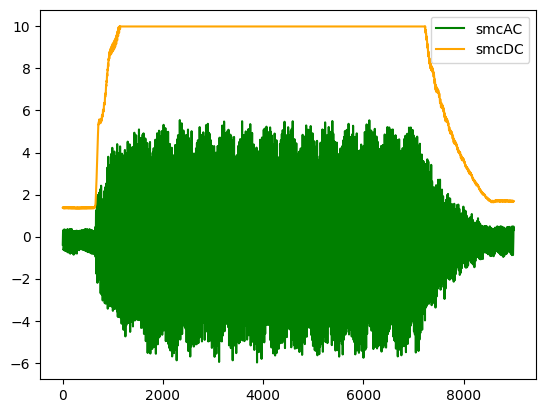

In [9]:
# look at cut number 167 (index 166)
fig, ax = plt.subplots()

ax.plot(data[0,166]['smcAC'],'g-',label='smcAC')
ax.plot(data[0,166]['smcDC'],color='orange',label='smcDC')

plt.legend()
plt.show()  # 確保顯示圖像

If you look at all the cuts, you'll find that cuts 18 and 95 (index 17 and 94) are off -- they should be discarded.

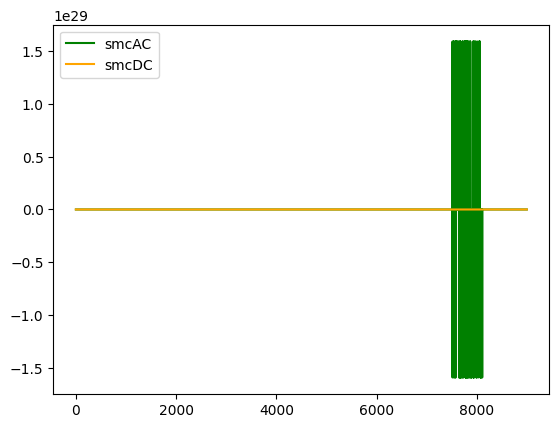

In [10]:
fig, ax = plt.subplots()

ax.plot(data[0,17]['smcAC'],'g-',label='smcAC')
ax.plot(data[0,17]['smcDC'],color='orange',label='smcDC')

plt.legend()
plt.show()  # 確保顯示圖像

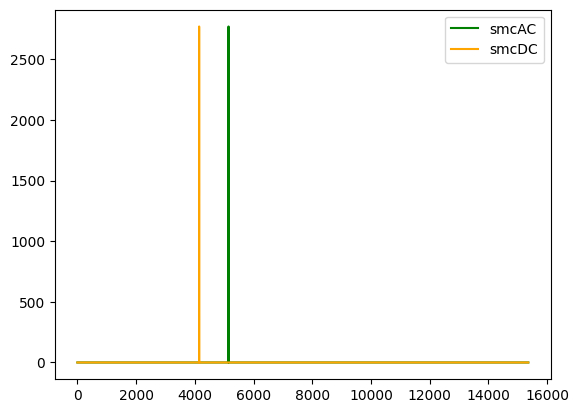

In [11]:
fig, ax = plt.subplots()

ax.plot(data[0,94]['smcAC'],'g-',label='smcAC')
ax.plot(data[0,94]['smcDC'],color='orange',label='smcDC')

plt.legend()
plt.show()  # 確保顯示圖像

Cut 106 is also weird...

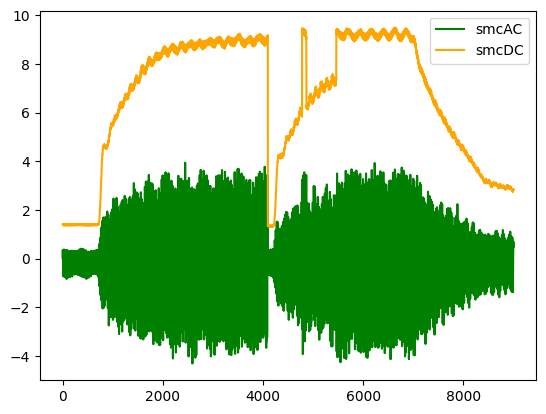

In [12]:
fig, ax = plt.subplots()

ax.plot(data[0,105]['smcAC'],'g-',label='smcAC')
ax.plot(data[0,105]['smcDC'],color='orange',label='smcDC')

plt.legend()
plt.show()  # 確保顯示圖像

We'lll create a pretty plot of all the six signals for a certain cut.

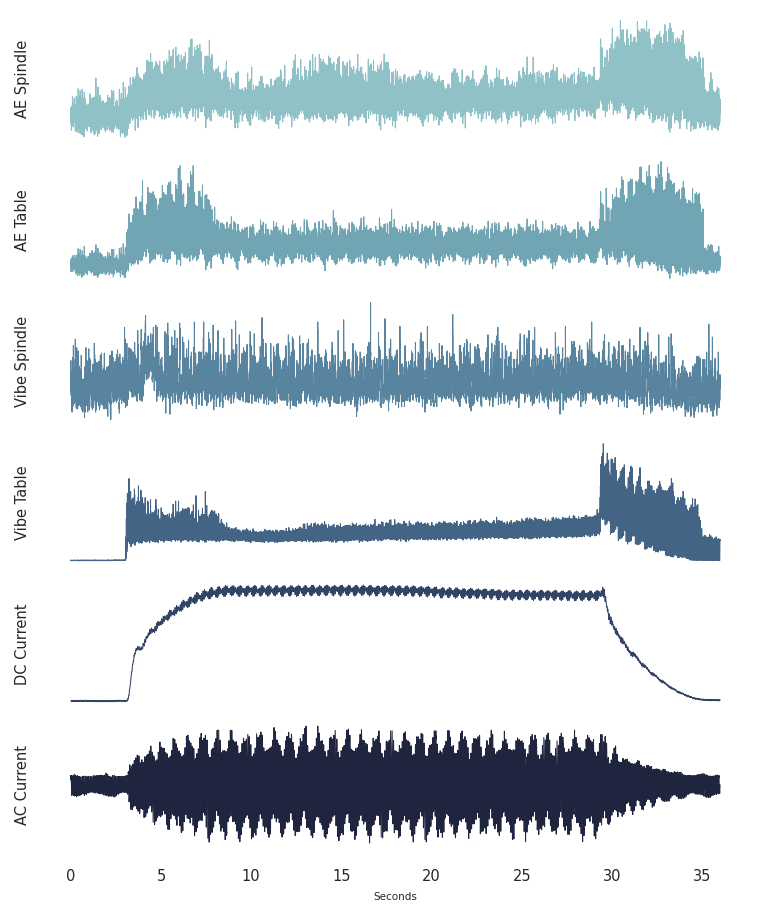

In [13]:
def plot_cut(cut_signal, signals_trend, cut_no):

    # define colour palette and seaborn style
    pal = sns.cubehelix_palette(6, rot=-0.25, light=0.7)
    sns.set(style="white", context="notebook")

    fig, axes = plt.subplots(
        6, 1, dpi=150, figsize=(5, 6), sharex=True, constrained_layout=True,
    )

    # the "revised" signal names so it looks good on the chart
    signal_names_revised = [
        "AE Spindle",
        "AE Table",
        "Vibe Spindle",
        "Vibe Table",
        "DC Current",
        "AC Current",
    ]

    # go through each of the signals
    for i in range(6):
        # plot the signal
        # note, we take the length of the signal (9000 data point)
        # and divide it by the frequency (250 Hz) to get the x-axis
        # into seconds
        axes[i].plot(np.arange(0,9000)/250.0, 
                     cut_signal[signals_trend[i]], 
                     color=pal[i], 
                     linewidth=0.5, 
                     alpha=1)
        
        axis_label = signal_names_revised[i]
        
        axes[i].set_ylabel(
            axis_label, fontsize=7,
        )

        # if it's not the last signal on the plot
        # we don't want to show the subplot outlines
        if i != 5:
            axes[i].spines["top"].set_visible(False)
            axes[i].spines["right"].set_visible(False)
            axes[i].spines["left"].set_visible(False)
            axes[i].spines["bottom"].set_visible(False)
            axes[i].set_yticks([]) # also remove the y-ticks, cause ugly
        
        # for the last signal we will show the x-axis labels
        # which are the length (in seconds) of the signal
        else:
            axes[i].spines["top"].set_visible(False)
            axes[i].spines["right"].set_visible(False)
            axes[i].spines["left"].set_visible(False)
            axes[i].spines["bottom"].set_visible(False)
            axes[i].set_yticks([])
            axes[i].tick_params(axis="x", labelsize=7)
            axes[i].set_xlabel('Seconds', size=5)


signals_trend = list(l[7:])  # there are 6 types of signals, smcAC to AE_spindle
signals_trend = signals_trend[::-1]  # reverse the signal order so that it is matching other charts

# we'll plot signal 146 (index 145)
cut_signal = data[0, 145]

plot_cut(cut_signal, signals_trend, "cut_146")
# plt.savefig('cut_signals.png',format='png') # save the figure
plt.show()

# 2. Data Prep

We'll create the X and y data sets and split them into their respective training/validation/testing sets. We'll save the data in hdf5 files.

In [14]:
data_file = folder_raw_data / "mill.mat"

prep = data_prep.DataPrep(data_file)

# load the labeled CSV (NaNs filled in by hand)
df_labels = pd.read_csv(
    folder_processed_data / 'labels_with_tool_class.csv'
)


# discard certain cuts as they are strange
cuts_remove = [17, 94]
df_labels.drop(cuts_remove, inplace=True)


X, y, dfy = prep.return_xy(df_labels, prep.data,prep.field_names[7:],window_size=64, stride=64, track_y=True)

X_train, X_test, dfy_train, dfy_test = train_test_split(X, dfy, test_size=0.33, random_state=15, 
                                                    stratify=dfy['class'])
X_val, X_test, dfy_val, dfy_test = train_test_split(X_test, dfy_test, test_size=0.50, random_state=10, 
                                                stratify=dfy_test['class'])

y_train = dfy_train['class'].to_numpy(dtype='int')
y_val = dfy_val['class'].to_numpy(dtype='int')
y_test = dfy_test['class'].to_numpy(dtype='int')


min_vals, max_vals = get_min_max(X_train)

# scale the data sets
X = scaler(X, min_vals, max_vals)
X_train = scaler(X_train, min_vals, max_vals)
X_val = scaler(X_val, min_vals, max_vals)
X_test = scaler(X_test, min_vals, max_vals)

print('Min/max values from X_train:')
print(min_vals)

print("\nShape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("\nShape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("\nShape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

# slim down the X_train and X_val
X_train_slim, y_train_slim = prep.remove_classes([1, 2], y_train, X_train)

print("\nShape of X_train_slim:", X_train_slim.shape)
print("Shape of y_train_slim:", y_train_slim.shape)

X_val_slim, y_val_slim = prep.remove_classes([1, 2], y_val, X_val)

print("\nShape of X_val_slim:", X_val_slim.shape)
print("Shape of y_val_slim:", y_val_slim.shape)

signal_names = prep.field_names[7:] # get signal names
signal_names = signal_names[::-1] # reverse order so that it is same as in data structure

Min/max values from X_train:
[-6.96777344  3.41796875  0.20263672  0.21850586  0.01464844  0.09094238]

Shape of X_train: (7751, 64, 6)
Shape of y_train: (7751,)

Shape of X_val: (1909, 64, 6)
Shape of y_val: (1909,)

Shape of X_test: (1910, 64, 6)
Shape of y_test: (1910,)

Shape of X_train_slim: (2831, 64, 6)
Shape of y_train_slim: (2831,)

Shape of X_val_slim: (697, 64, 6)
Shape of y_val_slim: (697,)


Save the data splits in the processed data folder (also save the "slimmed" down versions of the X_train and X_val).

In [15]:
# X_train, y_train
with h5py.File("data/processed/X_train.hdf5", "w") as f:
    dset = f.create_dataset("X_train", data=X_train)
with h5py.File("data/processed/y_train.hdf5", "w") as f:
    dset = f.create_dataset("y_train", data=y_train)

# X_val, y_val
with h5py.File("data/processed/X_val.hdf5", "w") as f:
    dset = f.create_dataset("X_val", data=X_val)
with h5py.File("data/processed/y_val.hdf5", "w") as f:
    dset = f.create_dataset("y_val", data=y_val)

# X_test, y_test
with h5py.File("data/processed/X_test.hdf5", "w") as f:
    dset = f.create_dataset("X_test", data=X_test)
with h5py.File("data/processed/y_test.hdf5", "w") as f:
    dset = f.create_dataset("y_test", data=y_test)


with h5py.File("data/processed/X_train_slim.hdf5", "w") as f:
    dset = f.create_dataset("X_train_slim", data=X_train_slim)
with h5py.File("data/processed/y_train_slim.hdf5", "w") as f:
    dset = f.create_dataset("y_train_slim", data=y_train_slim)

with h5py.File("data/processed/X_val_slim.hdf5", "w") as f:
    dset = f.create_dataset("X_val_slim", data=X_val_slim)
with h5py.File("data/processed/y_val_slim.hdf5", "w") as f:
    dset = f.create_dataset("y_val_slim", data=y_val_slim)

# 3. Train Models

In [16]:
# see what version of tensorflow is installed
print('TensorFlow version: ', tf.__version__)
print('Keras version: ', keras.__version__)
print('Tensorboard version:', tensorboard.__version__)

TensorFlow version:  2.11.1
Keras version:  2.11.0
Tensorboard version: 2.11.2


In [17]:
# see if you're using a GPU. You don't have to, but it
# will be faster if you're training many models
try:
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
except:
    print('GPU device not found')

Found GPU at: /device:GPU:0


2025-02-14 14:34:43.757829: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-14 14:34:43.768034: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-14 14:34:43.776992: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-14 14:34:43.777263: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at 

## 3.1 Fit Model Function
Function used to train the beta-VAE.

In [18]:
# build custom sampling function
# Sampling and rounded_accuracy code modified from Aurelion Geron, 
# https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
# used under Apache 2.0 License, https://github.com/ageron/handson-ml2/blob/master/LICENSE

K = keras.backend

# class for sampling embeddings in the latent space
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean


# rounded accuracy for the metric
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))


# fit the model
def model_fit(
    X_train_slim,
    X_val_slim,
    beta_value=1.25,
    codings_size=10,
    dilations=[1, 2, 4],
    conv_layers=1,
    seed=31,
    start_filter_no=32,
    kernel_size_1=2,
    epochs=10,
    earlystop_patience=8,
    verbose=0,
    compile_model_only=False,
):

    # try the first if it is the milling data
    # else it will be the CNC data
    try:
        _, window_size, feat = X_train_slim.shape

    except:
        window_size = X_train_slim.shape
        feat = 1

    date_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    tf.random.set_seed(seed)
    np.random.seed(seed)

    end_filter_no = start_filter_no

    inputs = keras.layers.Input(shape=[window_size, feat])
    z = inputs

    # ENCODER
    ####### TCN #######
    for i in range(0, conv_layers):
        z = TCN(
            nb_filters=start_filter_no,
            kernel_size=kernel_size_1,
            nb_stacks=1,
            dilations=dilations,
            padding="causal",
            use_skip_connections=True,
            dropout_rate=0.0,
            return_sequences=True,
            activation="selu",
            kernel_initializer="he_normal",
            use_batch_norm=False,
            use_layer_norm=False,
        )(z)

        z = keras.layers.BatchNormalization()(z)
        z = keras.layers.MaxPool1D(pool_size=2)(z)

    z = keras.layers.Flatten()(z)
    print("Shape of Z:", z.shape)

    codings_mean = keras.layers.Dense(codings_size)(z)

    codings_log_var = keras.layers.Dense(codings_size)(z)

    codings = Sampling()([codings_mean, codings_log_var])

    variational_encoder = keras.models.Model(
        inputs=[inputs], outputs=[codings_mean, codings_log_var, codings]
    )

    # DECODER
    decoder_inputs = keras.layers.Input(shape=[codings_size])

    x = keras.layers.Dense(
        start_filter_no * int((window_size / (2 ** conv_layers))), activation="selu"
    )(decoder_inputs)

    x = keras.layers.Reshape(
        target_shape=((int(window_size / (2 ** conv_layers))), end_filter_no)
    )(x)

    for i in range(0, conv_layers):
        x = keras.layers.UpSampling1D(size=2)(x)
        x = keras.layers.BatchNormalization()(x)

        x = TCN(
            nb_filters=start_filter_no,
            kernel_size=kernel_size_1,
            nb_stacks=1,
            dilations=dilations,
            padding="causal",
            use_skip_connections=True,
            dropout_rate=0.0,
            return_sequences=True,
            activation="selu",
            kernel_initializer="he_normal",
            use_batch_norm=False,
            use_layer_norm=False,
        )(x)

    outputs = keras.layers.Conv1D(
        feat, kernel_size=kernel_size_1, padding="same", activation="sigmoid"
    )(x)
    variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

    _, _, codings = variational_encoder(inputs)
    reconstructions = variational_decoder(codings)
    variational_ae_beta = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

    latent_loss = (
        -0.5
        * beta_value
        * K.sum(
            1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
            axis=-1,
        )
    )

    variational_ae_beta.add_loss(K.mean(latent_loss) / (window_size * feat))
    variational_ae_beta.compile(
        loss="binary_crossentropy",
        optimizer="adam",  #'rmsprop'
        metrics=[rounded_accuracy],
    )

    # count the number of parameters
    param_size = "{:0.2e}".format(
        variational_encoder.count_params() + variational_decoder.count_params()
    )

    # Uncomment these if you want to see the summary of the encoder/decoder
    # variational_encoder.summary()
    # variational_decoder.summary()

    # Model Name
    # b : beta value used in model
    # c : number of codings -- latent variables
    # l : numer of convolutional layers in encoder (also decoder)
    # f1 : the starting number of filters in the first convolution
    # k1 : kernel size for the first convolution
    # k2 : kernel size for the second convolution
    # d : whether dropout is used when sampling the latent space (either True or False)
    # p : number of parameters in the model (encoder + decoder params)
    # eps : number of epochs
    # pat : patience stopping number

    model_name = (
        "TBVAE-{}:_b={:.2f}_c={}_l={}_f1={}_k1={}_dil={}"
        "_p={}_eps={}_pat={}".format(
            date_time,
            beta_value,
            codings_size,
            conv_layers,
            start_filter_no,
            kernel_size_1,
            dilations,
            param_size,
            epochs,
            earlystop_patience,
        )
    )

    print("\n", model_name, "\n")

    if compile_model_only == False:
        # save the model summary into a text file (from stack overflow http://bit.ly/2DHI6fM)
        with open("models/saved_models/" + date_time + "_report.txt", "w") as fh:
            variational_encoder.summary(print_fn=lambda x: fh.write(x + "\n"))
            variational_decoder.summary(print_fn=lambda x: fh.write(x + "\n"))

        # # use tensorboard to track training
        # log_dir = "logs/" + date_time + "_" + model_name
        # tensorboard_callback = tf.keras.callbacks.TensorBoard(
        #     log_dir=log_dir, histogram_freq=0, update_freq="epoch", profile_batch=0
        # )

        earlystop_callback = tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=0.0002,
            patience=earlystop_patience,
            restore_best_weights=True,
            verbose=1,
        )

        history = variational_ae_beta.fit(
            X_train_slim,
            X_train_slim,
            epochs=epochs,
            batch_size=1024,
            shuffle=True,
            validation_data=(X_val_slim, X_val_slim),
            callbacks=[earlystop_callback,],  # tensorboard_callback,
            verbose=verbose,
        )

        return date_time, model_name, history, variational_ae_beta, variational_encoder

    else:

        return variational_ae_beta, variational_encoder

## 3.2 Random Search

Perform the random search to train the models. We will also save the trained models (both the encoder and decoder).

In [19]:
# load the data splits
(X_train, y_train, 
X_train_slim, y_train_slim,
X_val, y_val,
X_val_slim, y_val_slim,
X_test,y_test) = load_train_test(folder_processed_data) 

Setup the parameters for the random search and training. This is only an example of how you'd do the training (hence why we're only training for one epoch and only one random search iteration). You can modify the parameters as you see fit.

In [20]:
# Input the number of iterations you want to search over
random_search_iterations = 1

# random seed value from system input
ransdom_seed_input = 135

# parameters for beta-vae
p_bvae_grid = {
    "beta_value": uniform(loc=0.5, scale=9),
    "codings_size": sp_randint(5, 40),
    "conv_layers": [3, 2, 1],
    "start_filter_no": sp_randint(16, 128),
    "dilations": [[1, 2, 4, 8], [1, 2, 4], [1, 2]],
    "kernel_size_1": sp_randint(2, 9),
    "earlystop_patience": sp_randint(30, 50),
}

# epochs
epochs = 1

In [21]:
# folder to save models in
model_save_folder = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'_mill'

# create the folder
(folder_models / 'saved_models' / model_save_folder).mkdir(parents=True, exist_ok=True)

# create dataframe to store all the results
df_all = pd.DataFrame()

In [22]:
# setup parameters to sample
rng = np.random.RandomState(ransdom_seed_input)

# list of parameters in random search
p_bvae = list(ParameterSampler(p_bvae_grid, n_iter=random_search_iterations,random_state=rng))


for i, params in enumerate(p_bvae):
    print('\n### Run no.', i+1)
    
    ### TRY MODELS ###

    # BETA-VAE
        # parameters  
    beta_value =params["beta_value"]
    codings_size =params["codings_size"]
    conv_layers =params["conv_layers"]   
    start_filter_no =params["start_filter_no"] 
    kernel_size_1 = params["kernel_size_1"]
    dilations = params["dilations"]
    earlystop_patience=params["earlystop_patience"]
    

    seed = 16
    verbose = 1

    # try the model and if it doesn't work, go onto the next model
    # not always the best to use 'try' but good enough
    try:

        date_time, model_name, history, beta_vae_model, bvae_encoder = model_fit(
            X_train_slim,
            X_val_slim,
            beta_value=beta_value,
            codings_size=codings_size,
            conv_layers=conv_layers,
            seed=seed,
            start_filter_no=start_filter_no,
            kernel_size_1=kernel_size_1,
            dilations=dilations,
            epochs=epochs,
            earlystop_patience=earlystop_patience,
            verbose=verbose,
        )

        # save the model. How to: https://www.tensorflow.org/tutorials/keras/save_and_load
        # save model weights and model json
        model_save_dir_bvae = (
            folder_models / 'saved_models' / model_save_folder / (date_time + "_bvae")
        )
        model_save_dir_encoder = (
            folder_models / 'saved_models' / model_save_folder / (date_time + "_encoder")
        )

        # create the save paths
        Path(model_save_dir_bvae).mkdir(parents=True, exist_ok=True)
        Path(model_save_dir_encoder).mkdir(parents=True, exist_ok=True)

        # save entire bvae model
        model_as_json = beta_vae_model.to_json()
        with open(r"{}/model.json".format(str(model_save_dir_bvae)), "w",) as json_file:
            json_file.write(model_as_json)
        beta_vae_model.save_weights(str(model_save_dir_encoder) + "/weights.h5")

        # save encoder bvae model
        model_as_json = bvae_encoder.to_json()
        with open(r"{}/model.json".format(str(model_save_dir_encoder)), "w",) as json_file:
            json_file.write(model_as_json)
        bvae_encoder.save_weights(str(model_save_dir_encoder) + "/weights.h5")

        # get the model run history
        results = pd.DataFrame(history.history)
        epochs_trained = len(results)
        results["epochs_trained"] = epochs_trained
        # results = list(results[results['loss']==results['loss'].min()].to_numpy()) # only keep the top result, that is, the lowest val_loss
        results = list(
            results[results["val_loss"] == results["val_loss"].min()].to_numpy()
        )  # only keep the top result, that is, the lowest val_loss

        # append best result onto df_model_results dataframe
        if i == 0:
            cols = (
                list(p_bvae[0].keys())
                + list(history.history.keys())
                + ["epochs_trained"]
            )
            results = [[p_bvae[i][k] for k in p_bvae[i]] + list(results[0])]

        else:
            # create dataframe to store best result from model training
            cols = (
                list(p_bvae[0].keys())
                + list(history.history.keys())
                + ["epochs_trained"]
            )
            results = [[p_bvae[i][k] for k in p_bvae[i]] + list(results[0])]

        df = pd.DataFrame(results, columns=cols)

        df["date_time"] = date_time
        df["model_name"] = model_name

        # df_all = df_all.append(df, sort=False)
        df_all = pd.concat([df_all, df], ignore_index=True, sort=False)

        df_all.to_csv("results_interim_{}.csv".format(model_save_folder))

    except Exception as e:
        print(e)
        print("TRACEBACK")
        traceback.print_exc()
        pass

2025-02-14 14:34:44.556472: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero



### Run no. 1


2025-02-14 14:34:44.556894: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-14 14:34:44.557111: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-14 14:34:44.557655: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-14 14:34:44.557926: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-14 14:34:44.558134: I tensorflow/compiler/xla/stream_executo

Shape of Z: (None, 224)

 TBVAE-20250214-143444:_b=6.45_c=32_l=3_f1=28_k1=8_dil=[1, 2, 4]_p=2.65e+05_eps=1_pat=40 



2025-02-14 14:35:01.524866: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2025-02-14 14:35:02.552284: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x12605470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-14 14:35:02.552334: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): GRID P40-24Q, Compute Capability 6.1
2025-02-14 14:35:02.558298: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-14 14:35:02.677616: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3/3 [==============================] - 29s 2s/step - loss: 1.6853 - rounded_accuracy: 0.5509 - val_loss: 1150.8984 - val_rounded_accuracy: 0.6202


# 4. Analysis

Now we'll look at the best model that was trained during my experiment. This model should have been downloaded at the beginning, or is already in the model folder when you cloned the repo.

First, we're interested in see how imbalanced the data set is. Working with imbalanced data has its own challenges.

In [23]:
# reload the data sets
(X_train, y_train, 
X_train_slim, y_train_slim,
X_val, y_val,
X_val_slim, y_val_slim,
X_test,y_test) = load_train_test(folder_processed_data) 

In [24]:
# function to show the percentage of labels in y-labels
def y_shape_percentage(y_train, label):
    
    l = y_train
    
    print('shape {}:'.format(label), l.shape, 
          '\t\t0: {:.1%}'.format(len(l[l == 0])/len(l)), 
          '\t\t1: {:.1%}'.format(len(l[l == 1])/len(l)), 
          '\t\t2: {:.1%}'.format(len(l[l == 2])/len(l)))
    
# let's see what percentage of the data set splits are made up of healthy (0), degraded (1),
# and failed (2) labels
y_shape_percentage(y_train, 'y_train')
y_shape_percentage(y_val, 'y_val')
y_shape_percentage(y_test, 'y_test')

shape y_train: (7751,) 		0: 36.5% 		1: 56.2% 		2: 7.3%
shape y_val: (1909,) 		0: 36.5% 		1: 56.2% 		2: 7.3%
shape y_test: (1910,) 		0: 36.5% 		1: 56.2% 		2: 7.3%


Function needed to help in the analysis:

In [25]:
def mse(X_val, recon_val):
    """Calculate MSE for images in X_val and recon_val"""

    # need to calculate mean across the rows, and then across the columns
    return np.mean(
        np.square(X_val.astype("float32") - recon_val.astype("float32")), axis=1
    )


def mse_total(X_val, recon_val):
    """Calculate MSE for images in X_val and recon_val"""

    # need to calculate mean across the rows, and then across the columns
    return np.mean(
        np.mean(
            np.square(X_val.astype("float32") - recon_val.astype("float32")), axis=1
        ),
        axis=1,
    )


def moving_average(a, n=3):
    # from https://stackoverflow.com/a/14314054
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1 :] / n


def kl_divergence(mu, log_var):
    return -0.5 * K.sum(1 + log_var - K.exp(log_var) - K.square(mu), axis=-1,)


def sorted_x(X, dfy, case):
    index_keep = dfy[dfy["case"] == case].sort_values(by=["counter"].copy()).index
    X_sorted = X[index_keep]
    y_sorted = np.array(
        dfy[dfy["case"] == case].sort_values(by=["counter"])["class"].copy()
    )
    return X_sorted, y_sorted


def filter_x_material(X, dfy, material="cast_iron"):

    cast_iron_cases = [1, 2, 3, 4, 9, 10, 11, 12]
    steel_cases = list(list(set(range(1, 17)) - set(cast_iron_cases)))

    if material == "cast_iron":
        case_list = cast_iron_cases
    else:
        # material is 'steel'
        case_list = steel_cases

    index_keep = dfy[dfy["case"].isin(case_list)].copy().index
    X_sorted = X[index_keep]
    y_sorted = np.array(dfy[dfy["case"].isin(case_list)]["class"].copy(), dtype="int")
    return X_sorted, y_sorted


def filter_x_feed(X, dfy, feed):
    fast_feed_cases = [1, 2, 5, 8, 9, 12, 14, 16]
    slow_feed_cases = list(list(set(range(1, 17)) - set(fast_feed_cases)))

    if feed == 0.5:
        case_list = fast_feed_cases
    else:
        # feed is 0.25
        case_list = slow_feed_cases

    index_keep = dfy[dfy["case"].isin(case_list)].copy().index
    X_sorted = X[index_keep]
    y_sorted = np.array(dfy[dfy["case"].isin(case_list)]["class"].copy(), dtype="int")
    return X_sorted, y_sorted


def filter_x_depth(X, dfy, feed):
    deep_cases = [1, 4, 5, 6, 9, 10, 15, 16]
    shallow_cases = list(list(set(range(1, 17)) - set(deep_cases)))

    if feed == 1.5:
        case_list = deep_cases
    else:
        # depth is 0.75
        case_list = shallow_cases

    index_keep = dfy[dfy["case"].isin(case_list)].copy().index
    X_sorted = X[index_keep]
    y_sorted = np.array(dfy[dfy["case"].isin(case_list)]["class"].copy(), dtype="int")
    return X_sorted, y_sorted


def build_mre_scores(
    model, X,
):
    """Build the mean-reconstruction-error values from the """

    # build the MRE values for each individual signal (mres_all) and for the average across
    # all six signals (mre_avg)
    mres_all = []  # instantiate the lists to store the values
    dummies_all = []
    mres_avg = []
    dummies_avg = []

    # X's should already be scaled
    # X = scaler(X, min_vals, max_vals)
    recon = model.predict(X, batch_size=64)
    # all the signals
    mre_all = mse(X, recon)

    # average of the signals
    mre_avg = mse_total(X, recon)

    return mre_all, mre_avg


def build_kls_scores(
    encoder, X,
):
    codings_mean, codings_log_var, codings = encoder.predict(X, batch_size=64)
    kls = np.array(kl_divergence(codings_mean, codings_log_var))
    return kls


def pr_auc_kl(
    encoder,
    X,
    y,
    grid_iterations=10,
    date_model_ran="date",
    model_name="encoder",
    class_to_remove=[2],
):

    """
    Function that gets the precision and recall scores for the encoder 
    """

    codings_mean, codings_log_var, codings = encoder.predict(X, batch_size=64)

    kls = np.array(kl_divergence(codings_mean, codings_log_var))
    kls = np.reshape(kls, (-1, 1))

    lower_bound = np.min(kls)
    upper_bound = np.max(kls)

    recon_check = threshold.SelectThreshold(
        encoder,
        X,
        y,
        X,
        X,
        y,
        X,
        class_to_remove,
        class_names=["0", "1", "2"],
        model_name=model_name,
        date_time=date_model_ran,
    )

    (
        best_threshold,
        best_roc_score,
        precisions,
        recalls,
        tprs,
        fprs,
    ) = recon_check.threshold_grid_search(
        y, lower_bound, upper_bound, kls, grid_iterations,
    )

    pr_auc_score_train = auc(recalls, precisions)
    roc_auc_score_train = auc(fprs, tprs)
    
    return (
        pr_auc_score_train,
        roc_auc_score_train,
        recalls,
        precisions,
        tprs,
        fprs,
        best_threshold,
    )

In [26]:
def get_latent_input_anomaly_scores(
    model_name,
    saved_model_dir,
    class_to_remove,
    X_train,
    y_train,
    X_val,
    y_val,
    grid_iterations,
    search_iterations,
    X_train_slim=X_train_slim,
    X_val_slim=X_val_slim,
):
    """
    Function that gets does an iterative grid search to get the precision and recall 
    scores for the anomaly detection model in the latent space and 
    """

    date_model_ran = model_name.split("_")[0]

    # input space anomaly detection
    loaded_json = open(
        r"{}/{}/model.json".format(saved_model_dir, model_name), "r"
    ).read()
    
    beta_vae_model = model_from_json(
        loaded_json, custom_objects={"TCN": TCN, "Sampling": Sampling}
    )

    # restore weights
    beta_vae_model.load_weights(r"{}/{}/weights.h5".format(saved_model_dir, model_name))

    recon_check = threshold.SelectThreshold(
        beta_vae_model,
        X_train,
        y_train,
        X_train_slim,
        X_val,
        y_val,
        X_val_slim,
        class_to_remove,
        class_names=["0", "1", "2"],
        model_name=model_name,
        date_time=date_model_ran,
    )

    df = recon_check.compare_error_method(
        show_results=False,
        grid_iterations=grid_iterations,
        search_iterations=search_iterations,
    )

    # latent space anomaly detection
    loaded_json = open(
        r"{}/{}/model.json".format(saved_model_dir, date_model_ran + "_encoder"), "r"
    ).read()
    
    encoder = model_from_json(
        loaded_json, custom_objects={"TCN": TCN, "Sampling": Sampling}
    )

    # restore weights
    encoder.load_weights(
        r"{}/{}/weights.h5".format(saved_model_dir, date_model_ran + "_encoder")
    )

    prauc_train_kls = []
    prauc_val_kls = []
    roc_train_kls = []
    roc_val_kls = []
    recalls_array = []
    precisions_array = []
    tprs_array = []
    fprs_array = []

    for i in range(search_iterations):
        print("search_iter:", i)
        # train
        (
            pr_auc_score_train,
            roc_auc_score_train,
            recalls,
            precisions,
            tprs,
            fprs,
            best_threshold_kl,
        ) = pr_auc_kl(
            encoder,
            X_train,
            y_train,
            grid_iterations=grid_iterations,
            date_model_ran="date",
            model_name="encoder",
            class_to_remove=class_to_remove,
        )

        prauc_train_kls.append(pr_auc_score_train)
        roc_train_kls.append(roc_auc_score_train)

        # val
        (
            pr_auc_score_val,
            roc_auc_score_val,
            recalls,
            precisions,
            tprs,
            fprs,
            best_threshold,
        ) = pr_auc_kl(
            encoder,
            X_val,
            y_val,
            grid_iterations=grid_iterations,
            date_model_ran="date",
            model_name="encoder",
            class_to_remove=class_to_remove,
        )

        prauc_val_kls.append(pr_auc_score_val)
        roc_val_kls.append(roc_auc_score_val)
        recalls_array.append(recalls)
        precisions_array.append(precisions)
        tprs_array.append(tprs)
        fprs_array.append(fprs)

    df["pr_auc_train_score_kl"] = np.mean(np.array(prauc_train_kls))
    df["pr_auc_val_score_kl"] = np.mean(np.array(prauc_val_kls))
    df["roc_train_score_kl"] = np.mean(np.array(roc_train_kls))
    df["roc_val_score_kl"] = np.mean(np.array(roc_val_kls))
    df["best_threshold_kl"] = best_threshold_kl

    recalls_array = np.array(recalls_array)
    precisions_array = np.array(precisions_array)
    tprs_array = np.array(tprs_array)
    fprs_array = np.array(fprs_array)

    return df, recalls_array, precisions_array, tprs_array, fprs_array


## 4.1 Table of Best Anomaly Detection Model

In [27]:
model_folder = "./models/best_models"

# the best model from the original grid search
model_name = "20200620-053315_bvae"

grid_iterations = 250
search_iterations = 1

# get results for train and validation sets
dfr_val, _, _, _, _ = get_latent_input_anomaly_scores(
    model_name,
    model_folder,
    [2],
    X_train,
    y_train,
    X_val,
    y_val,
    grid_iterations=grid_iterations,
    search_iterations=search_iterations,
    X_train_slim=X_train_slim,
    X_val_slim=X_val_slim,
)

date_time = dfr_val["date_time"][0]
best_threshold = dfr_val["best_threshold"][0]
best_threshold_kl = dfr_val["best_threshold_kl"][0]
pr_auc_train_score = dfr_val["pr_auc_train_score"][0]
pr_auc_val_score = dfr_val["pr_auc_val_score"][0]
pr_auc_train_score_kl = dfr_val["pr_auc_train_score_kl"][0]
pr_auc_val_score_kl = dfr_val["pr_auc_val_score_kl"][0]

# get results for test set
dfr_test, recalls, precisions, tprs, fprs = get_latent_input_anomaly_scores(
    model_name,
    model_folder,
    [2],
    X_train,
    y_train,
    X_test,
    y_test,
    grid_iterations=grid_iterations,
    search_iterations=search_iterations,
    X_train_slim=X_train_slim,
    X_val_slim=X_val_slim,
)

best_threshold_mre_test = dfr_test["best_threshold"][0]
best_threshold_kl_test = dfr_test["best_threshold_kl"][0]
pr_auc_test_score = dfr_test["pr_auc_val_score"][0]
pr_auc_test_score_kl = dfr_test["pr_auc_val_score_kl"][0]


# collate the results into one dataframe
df_result = pd.DataFrame()

df_result["Data Set"] = ["train", "validation", "test"]

df_result["PR-AUC Input Space"] = [
    pr_auc_train_score,
    pr_auc_val_score,
    pr_auc_test_score,
]

df_result["PR-AUC Latent Space"] = [
    pr_auc_train_score_kl,
    pr_auc_val_score_kl,
    pr_auc_test_score_kl,
]

clear_output(wait=True)
df_result

,Data Set,PR-AUC Input Space,PR-AUC Latent Space
0,train,0.356268,0.393464
1,validation,0.425274,0.493395
2,test,0.432424,0.449931


## 4.2 Precision-Recall Curve

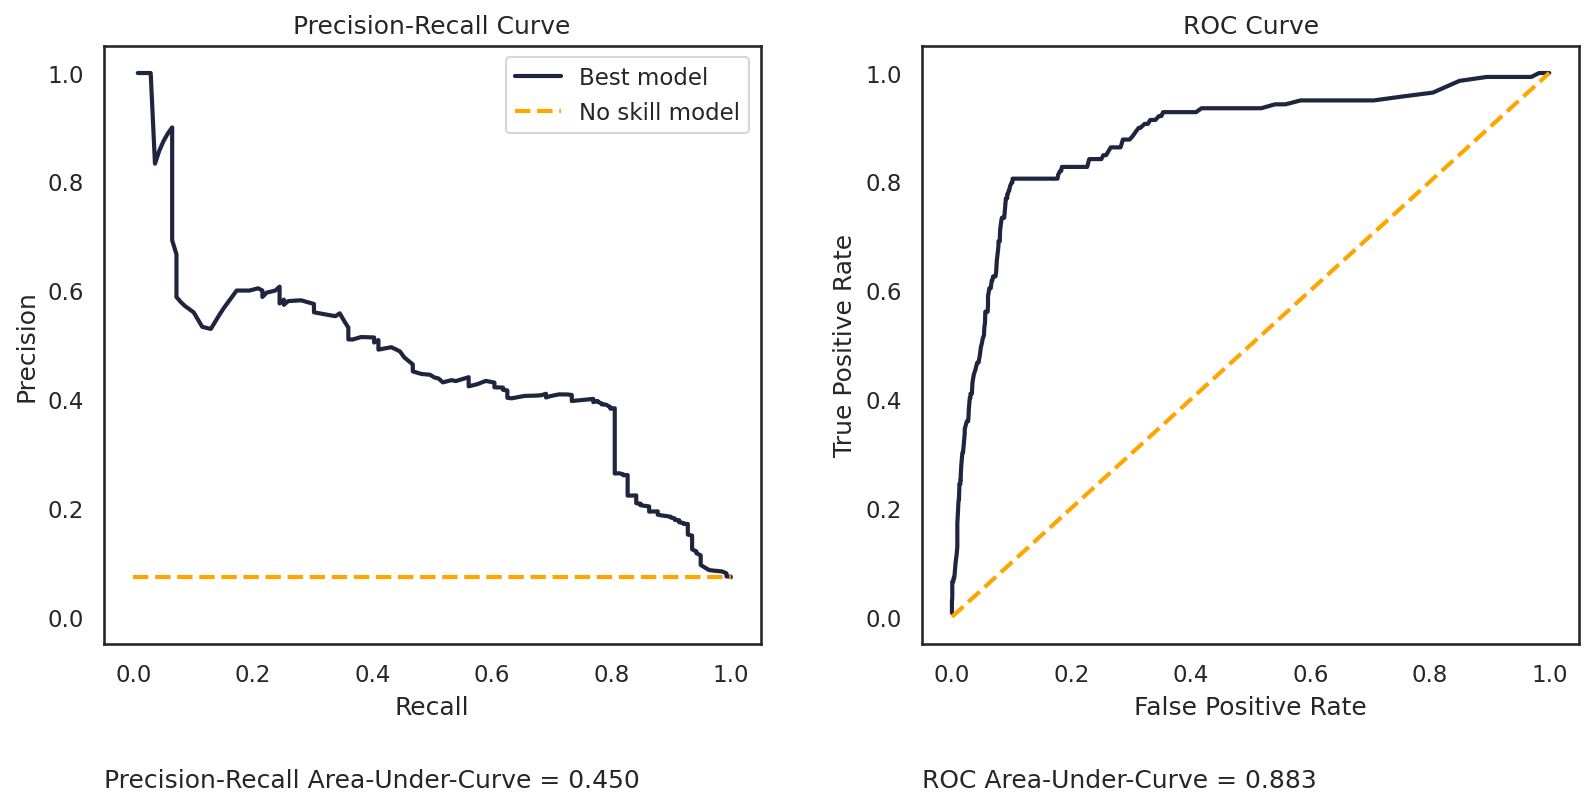

In [28]:
roc_auc_val = auc(fprs[0, :], tprs[0, :])
pr_auc_val = auc(recalls[0, :], precisions[0, :])

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True, dpi=150)
fig.tight_layout(pad=5.0)

pal = sns.cubehelix_palette(6, rot=-0.25, light=0.7)

axes[0].plot(
    recalls[0, :],
    precisions[0, :],
    marker="",
    label="Best model",
    color=pal[5],
    linewidth=2,
)

axes[0].plot(
    np.array([0, 1]),
    np.array([0.073, 0.073]),
    marker="",
    linestyle="--",
    label="No skill model",
    color="orange",
    linewidth=2,
)

axes[0].legend()
axes[0].title.set_text("Precision-Recall Curve")
axes[0].set_xlabel("Recall")
axes[0].set_ylabel("Precision")
axes[0].text(
    x=-0.05,
    y=-0.3,
    s="Precision-Recall Area-Under-Curve = {:.3f}".format(pr_auc_val),
    horizontalalignment="left",
    verticalalignment="center",
    rotation="horizontal",
    alpha=1,
)

axes[1].plot(
    fprs[0, :], tprs[0, :], marker="", label="Best model", color=pal[5], linewidth=2,
)

axes[1].plot(
    np.array([0, 1]),
    np.array([0, 1]),
    marker="",
    linestyle="--",
    label="No skill",
    color="orange",
    linewidth=2,
)

axes[1].title.set_text("ROC Curve")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].text(
    x=-0.05,
    y=-0.3,
    s="ROC Area-Under-Curve = {:.3f}".format(roc_auc_val),
    horizontalalignment="left",
    verticalalignment="center",
    rotation="horizontal",
    alpha=1,
)

for ax in axes.flatten():
    ax.yaxis.set_tick_params(labelleft=True, which="major")
    ax.grid(False)

plt.show()

In [29]:
final_best_threshold_mre = best_threshold
final_best_threshold_kl = best_threshold_kl

print('Approximate best threshold for Input Space: best_threshold_mre, ', final_best_threshold_mre)
print('Approximate best threshold for Latent Space: best_threshold_kl,', final_best_threshold_kl)

Approximate best threshold for Input Space: best_threshold_mre,  168.87101779098666
Approximate best threshold for Latent Space: best_threshold_kl, 45.58019222259523


## 4.3 Violin Plots for Input and Latent Space

Load both the encoder and full model (both the encoder and decoder) for the best model.

In [30]:
# load best beta-VAE for input space anomaly detection
folder_name_model = '20200620-053315_bvae'

loaded_json = open(r'models/best_models/{}/model.json'.format(folder_name_model), 'r').read()
beta_vae_model = model_from_json(loaded_json, custom_objects={'TCN': TCN, 'Sampling': Sampling})

# restore weights
beta_vae_model.load_weights(r'models/best_models/{}/weights.h5'.format(folder_name_model))

# load best encoder for latent space anomaly detection
folder_name_encoder = '20200620-053315_encoder'

loaded_json = open(r'models/best_models/{}/model.json'.format(folder_name_encoder), 'r').read()
encoder = model_from_json(loaded_json, custom_objects={'TCN': TCN, 'Sampling': Sampling})

# restore weights
encoder.load_weights(r'models/best_models/{}/weights.h5'.format(folder_name_encoder))

In [31]:
def create_recon_df(mre_avg, dfy_data):

    y_data = dfy_data["class"].to_numpy()

    def metal_type(cols):
        case = int(cols[0])

        if case in [1, 2, 3, 4, 9, 10, 11, 12]:
            return "cast iron"

        else:
            return "steel"

    def feed_rate(cols):
        case = int(cols[0])

        if case in [1, 2, 5, 8, 9, 12, 14, 16]:
            return 0.5

        else:
            return 0.25

    def depth_cut(cols):
        case = int(cols[0])

        if case in [1, 4, 5, 6, 9, 10, 15, 16]:
            return 1.5

        else:
            return 0.75

    df1 = pd.DataFrame()
    df1["recon_metric"] = mre_avg
    df1["class"] = y_data
    df1["case"] = dfy_data["case"].to_numpy()
    df1["metal"] = df1[["case"]].apply(metal_type, axis=1)
    df1["feed"] = df1[["case"]].apply(feed_rate, axis=1)
    df1["depth"] = df1[["case"]].apply(depth_cut, axis=1)

    return df1

In [32]:
def violin_plot(
    model,
    X,
    dfy,
    mre_or_kls="mre",
    best_threshold=0.034,
    caption="Distribution of Tool States",
    save_name="distrib.png",
):

    if mre_or_kls == "mre":
        _, metric = build_mre_scores(model, X)
    else:
        metric = build_kls_scores(model, X)

    df1 = create_recon_df(metric, dfy)

    colors = ["#e31a1c", "black"]

    # Set your custom color palette
    customPalette = sns.set_palette(sns.color_palette(colors))

    min_x = df1["recon_metric"].min()
    max_x = df1["recon_metric"].max() + df1["recon_metric"].max() * 0.05

    min_y = -0.5
    max_y = 2.7

    fig, ax = plt.subplots(1, 1, figsize=(8, 10),)

    # violin plot
    ax = sns.violinplot(
        x="recon_metric",
        y="class",
        data=df1,
        scale="count",
        inner=None,
        linewidth=2,
        color="white",
        saturation=1,
        cut=0,
        orient="h",
        zorder=0,
        width=1,
    )

    sns.despine(left=True)

    # strip plot
    ax = sns.stripplot(
        x="recon_metric",
        y="class",
        data=df1,
        size=6,
        jitter=0.15,
        color="black",
        linewidth=0.5,
        marker="o",
        edgecolor=None,
        alpha=0.1,
        palette=customPalette,
        zorder=4,
        orient="h",
    )

    # vertical line
    ax.plot(
        [best_threshold, best_threshold],
        [min_y, max_y],
        linestyle="--",
        label="",
        color="#d62728",
    )

    # add the fill areas for the predicted Failed and Healthy regions
    plt.fill_between(
        x=[0, best_threshold],
        y1=min_y,
        y2=max_y,
        color="#b2df8a",
        alpha=0.4,
        linewidth=0,
        zorder=0,
    )

    plt.fill_between(
        x=[best_threshold, max_x + 0.001],
        y1=min_y,
        y2=max_y,
        color="#e31a1c",
        alpha=0.1,
        linewidth=0,
        zorder=0,
    )

    # add text for the predicted Failed and Healthy regions
    ax.text(
        x=0 + (best_threshold) / 2,
        y=max_y - 0.2,
        s="Normal\nPrediction",
        horizontalalignment="center",
        verticalalignment="center",
        size=14,
        color="#33a02c",
        rotation="horizontal",
        weight="normal",
    )

    ax.text(
        x=best_threshold + (max_x - best_threshold) / 2,
        y=max_y - 0.2,
        s="Abnormal (failed)\nPrediction",
        horizontalalignment="center",
        verticalalignment="center",
        size=14,
        color="#d62728",
        rotation="horizontal",
        weight="normal",
    )

    # Set text labels and properties.
    plt.yticks([0, 1, 2], ["Healthy", "Degraded", "Failed"], weight="normal", size=14)
    plt.xlabel("")  # remove x-label
    plt.ylabel("")  # remove y-label

    plt.tick_params(
        axis="both",  # changes apply to the x-axis
        which="both",  # both major and minor ticks are affected
        bottom=False,
        left=False,
    )

    ax.axes.get_xaxis().set_visible(False)  # hide x-axis
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    plt.title(caption, x=0.05, y=0.97, loc="left", weight="normal", size=14)
    plt.show()

30/30 [==============================] - 2s 7ms/step


/tmp/ipykernel_857645/2323154611.py:32: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  ax = sns.violinplot(


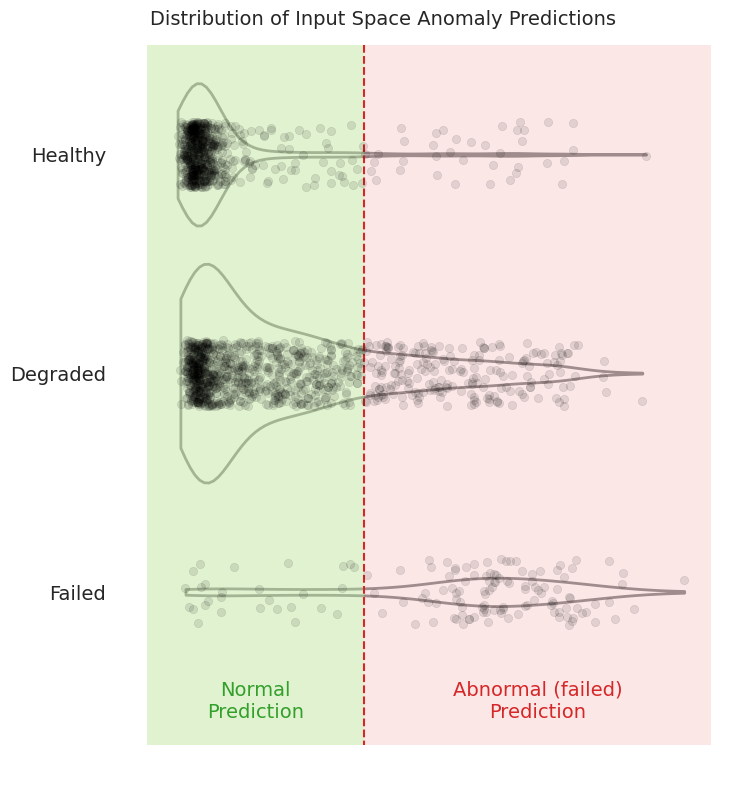

In [33]:
violin_plot(
    beta_vae_model,
    X_test,
    dfy_test,
    mre_or_kls="mre",
    best_threshold=final_best_threshold_mre,
    caption="Distribution of Input Space Anomaly Predictions",
    save_name="dist_input_600dpi.pdf",
)

30/30 [==============================] - 1s 4ms/step


/tmp/ipykernel_857645/2323154611.py:32: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  ax = sns.violinplot(


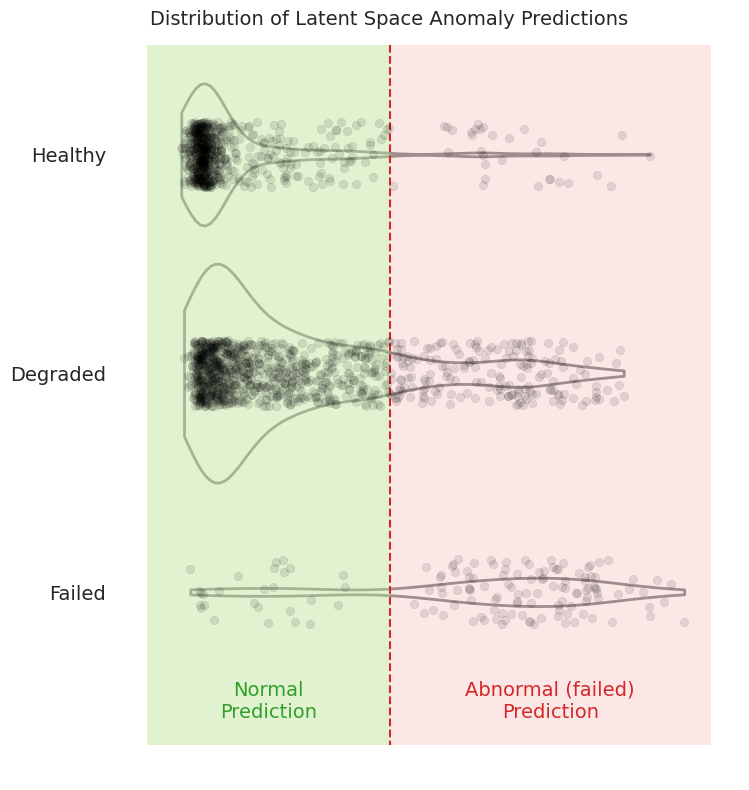

In [34]:
violin_plot(
    encoder,
    X_test,
    dfy_test,
    mre_or_kls="kls",
    best_threshold=final_best_threshold_kl,
    caption="Distribution of Latent Space Anomaly Predictions",
    save_name="dist_latent_600dpi.pdf",
)

## 4.4 Compare Results from Different Cutting Parameters
Now we will look at the cutting parameters in isolation and see which ones have the biggest impact on the best model.

In [35]:
def get_results(
    model_name,
    model_folder,
    grid_iterations,
    search_iterations,
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
):

    # get results for train and validation sets
    dfr_val, _, _, _, _ = get_latent_input_anomaly_scores(
        model_name,
        model_folder,
        [2],
        X_train,
        y_train,
        X_val,
        y_val,
        grid_iterations=grid_iterations,
        search_iterations=search_iterations,
        X_train_slim=X_train_slim,
        X_val_slim=X_val_slim,
    )

    date_time = dfr_val["date_time"][0]
    best_threshold = dfr_val["best_threshold"][0]
    best_threshold_kl = dfr_val["best_threshold_kl"][0]
    pr_auc_train_score = dfr_val["pr_auc_train_score"][0]
    pr_auc_val_score = dfr_val["pr_auc_val_score"][0]
    pr_auc_train_score_kl = dfr_val["pr_auc_train_score_kl"][0]
    pr_auc_val_score_kl = dfr_val["pr_auc_val_score_kl"][0]

    # get results for test set
    dfr_test, _, _, _, _ = get_latent_input_anomaly_scores(
        model_name,
        model_folder,
        [2],
        X_train,
        y_train,
        X_test,
        y_test,
        grid_iterations=grid_iterations,
        search_iterations=search_iterations,
        X_train_slim=X_train_slim,
        X_val_slim=X_val_slim,
    )

    best_threshold_mre_test = dfr_test["best_threshold"][0]
    best_threshold_kl_test = dfr_test["best_threshold_kl"][0]
    pr_auc_test_score = dfr_test["pr_auc_val_score"][0]
    pr_auc_test_score_kl = dfr_test["pr_auc_val_score_kl"][0]

    # collate the results into one dataframe
    df_result = pd.DataFrame()

    df_result["Data Set"] = ["train", "validation", "test"]
    df_result["PR-AUC Input Space"] = [
        pr_auc_train_score,
        pr_auc_val_score,
        pr_auc_test_score,
    ]
    
    df_result["PR-AUC Latent Space"] = [
        pr_auc_train_score_kl,
        pr_auc_val_score_kl,
        pr_auc_test_score_kl,
    ]
    
    return df_result

In [36]:
model_folder = './models/best_models'
model_name = '20200620-053315_bvae'

grid_iterations = 250
search_iterations = 1 # <---- CHANGE THIS TO 4 TO GET SAME RESULTS AS IN PAPER (but takes loooong to run)

# look at different material types
# STEEL
X_train_mat1, y_train_mat1 =  filter_x_material(X, dfy_train, 'steel')
X_val_mat1, y_val_mat1 =  filter_x_material(X, dfy_val, 'steel')
X_test_mat1, y_test_mat1 =  filter_x_material(X, dfy_test, 'steel')

dfr_steel = get_results(model_name, model_folder, grid_iterations, search_iterations, 
                X_train_mat1, y_train_mat1, X_val_mat1, y_val_mat1, X_test_mat1, y_test_mat1)

# CAST-IRON
X_train_mat2, y_train_mat2 =  filter_x_material(X, dfy_train, 'cast_iron')
X_val_mat2, y_val_mat2 =  filter_x_material(X, dfy_val, 'cast_iron')
X_test_mat2, y_test_mat2 =  filter_x_material(X, dfy_test, 'cast_iron')

dfr_iron = get_results(model_name, model_folder, grid_iterations, search_iterations, 
                X_train_mat2, y_train_mat2, X_val_mat2, y_val_mat2, X_test_mat2, y_test_mat2)

# look at different feeds
# 0.5
X_train_f1, y_train_f1 =  filter_x_feed(X, dfy_train, 0.5)
X_val_f1, y_val_f1 =  filter_x_feed(X, dfy_val, 0.5)
X_test_f1, y_test_f1 =  filter_x_feed(X, dfy_test, 0.5)

dfr_fast = get_results(model_name, model_folder, grid_iterations, search_iterations, 
                X_train_f1, y_train_f1, X_val_f1, y_val_f1, X_test_f1, y_test_f1)

# 0.25
X_train_f2, y_train_f2 =  filter_x_feed(X, dfy_train, 0.25)
X_val_f2, y_val_f2 =  filter_x_feed(X, dfy_val, 0.25)
X_test_f2, y_test_f2 =  filter_x_feed(X, dfy_test, 0.25)

dfr_slow = get_results(model_name, model_folder, grid_iterations, search_iterations, 
                X_train_f2, y_train_f2, X_val_f2, y_val_f2, X_test_f2, y_test_f2)

# look at different depths of cut
# 1.5
X_train_d1, y_train_d1 =  filter_x_depth(X, dfy_train, 1.5)
X_val_d1, y_val_d1 =  filter_x_depth(X, dfy_val, 1.5)
X_test_d1, y_test_d1 =  filter_x_depth(X, dfy_test, 1.5)

dfr_deep = get_results(model_name, model_folder, grid_iterations, search_iterations, 
                X_train_d1, y_train_d1, X_val_d1, y_val_d1, X_test_d1, y_test_d1)

# 0.75
X_train_d2, y_train_d2 =  filter_x_depth(X, dfy_train, 0.75)
X_val_d2, y_val_d2 =  filter_x_depth(X, dfy_val, 0.75)
X_test_d2, y_test_d2 =  filter_x_depth(X, dfy_test, 0.75)

dfr_shallow = get_results(model_name, model_folder, grid_iterations, search_iterations, 
                X_train_d2, y_train_d2, X_val_d2, y_val_d2, X_test_d2, y_test_d2)

clear_output(wait=False)

In [37]:
dfr_deep

,Data Set,PR-AUC Input Space,PR-AUC Latent Space
0,train,0.115502,0.118633
1,validation,0.113257,0.124065
2,test,0.130738,0.158938


In [38]:
dfr_shallow

,Data Set,PR-AUC Input Space,PR-AUC Latent Space
0,train,0.719430,0.752468
1,validation,0.811140,0.829849
2,test,0.727132,0.804361


In [39]:
dfr_steel

,Data Set,PR-AUC Input Space,PR-AUC Latent Space
0,train,0.425034,0.477521
1,validation,0.571768,0.579512
2,test,0.462602,0.522996


In [40]:
dfr_iron

,Data Set,PR-AUC Input Space,PR-AUC Latent Space
0,train,0.041625,0.041689
1,validation,0.037986,0.037067
2,test,0.028802,0.029680


In [41]:
dfr_fast

,Data Set,PR-AUC Input Space,PR-AUC Latent Space
0,train,0.139540,0.144827
1,validation,0.221114,0.231796
2,test,0.192561,0.209018


In [42]:
dfr_slow

,Data Set,PR-AUC Input Space,PR-AUC Latent Space
0,train,0.569513,0.599790
1,validation,0.664375,0.672304
2,test,0.558943,0.645599


In [43]:
slow_test_score = dfr_slow[dfr_slow['Data Set']=='test']['PR-AUC Latent Space'].to_numpy()[0]
fast_test_score = dfr_fast[dfr_fast['Data Set']=='test']['PR-AUC Latent Space'].to_numpy()[0]
steel_test_score = dfr_steel[dfr_steel['Data Set']=='test']['PR-AUC Latent Space'].to_numpy()[0]
iron_test_score = dfr_iron[dfr_iron['Data Set']=='test']['PR-AUC Latent Space'].to_numpy()[0]
deep_test_score = dfr_deep[dfr_deep['Data Set']=='test']['PR-AUC Latent Space'].to_numpy()[0]
shallow_test_score = dfr_shallow[dfr_shallow['Data Set']=='test']['PR-AUC Latent Space'].to_numpy()[0]

In [44]:
cutting_parameters = [
    "Steel",
    "Iron",
    "0.25 Feed\nRate",
    "0.5 Feed\nRate",
    "1.5 Depth",
    "0.75 Depth",
]

pr_auc_latent = [
    steel_test_score,
    iron_test_score,
    slow_test_score,
    fast_test_score,
    deep_test_score,
    shallow_test_score,
]

dfr_param = (
    pd.DataFrame(
        {"Parameter": cutting_parameters, "PR-AUC Latent Score": pr_auc_latent}
    )
    .round(3)
    .sort_values("PR-AUC Latent Score", ascending=False)
)

dfr_param

,Parameter,PR-AUC Latent Score
5,0.75 Depth,0.804
2,0.25 Feed\nRate,0.646
0,Steel,0.523
3,0.5 Feed\nRate,0.209
4,1.5 Depth,0.159
1,Iron,0.030


/tmp/ipykernel_857645/3234241463.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


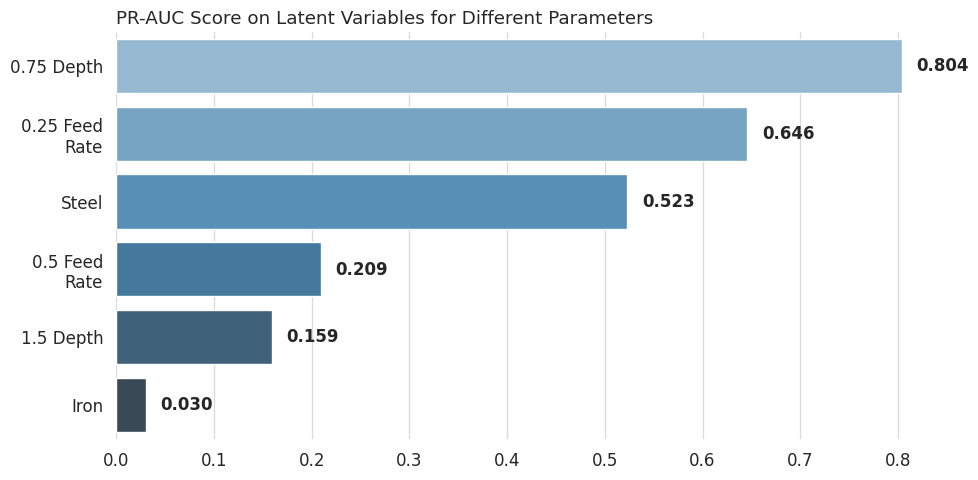

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 5))

sns.set(font_scale=1.1, style="whitegrid")
ax = sns.barplot(
    x="PR-AUC Latent Score", y="Parameter", data=dfr_param, palette="Blues_d"
)

# 在條形圖上加上數值標籤
for p in ax.patches:
    space = 0.015
    _x = p.get_x() + p.get_width() + space
    _y = p.get_y() + p.get_height() / 2
    value = f"{p.get_width():.3f}"  # 限制小數位數
    ax.text(_x, _y, value, ha="left", va="center", weight="semibold", size=12)

ax.spines["bottom"].set_visible(True)
ax.set_ylabel("")
ax.set_xlabel("")
ax.grid(alpha=0.7, linewidth=1, axis="x")

plt.title("PR-AUC Score on Latent Variables for Different Parameters", loc="left")

sns.despine(left=True, bottom=True)

plt.tight_layout()  # 確保圖表完整顯示
plt.show()

In [49]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5),)

# sns.set(font_scale=1.1, style="whitegrid")
# ax = sns.barplot(
#     "PR-AUC Latent Score", y="Parameter", data=dfr_param, palette="Blues_d",
# )
# for p in ax.patches:
#     # help from https://stackoverflow.com/a/56780852/9214620
#     space = 0.015
#     _x = p.get_x() + p.get_width() + float(space)
#     _y = p.get_y() + p.get_height() / 2
#     value = p.get_width()
#     ax.text(_x, _y, value, ha="left", va="center", weight="semibold", size=12)

# ax.spines["bottom"].set_visible(True)
# ax.set_ylabel("")
# ax.set_xlabel("")
# ax.grid(alpha=0.7, linewidth=1, axis="x")
# ax.set_xticks([0])
# ax.set_xticklabels([])
# plt.title("PR-AUC Score on Latent Variables for Different Parameters", loc="left")

# sns.despine(left=True, bottom=True)
# # plt.savefig('prauc_params_1.pdf',dpi=600,bbox_inches = "tight")
# plt.show()

TypeError: barplot() got multiple values for argument 'data'

## 4.5 Compare Results for Different Signals

Look at the results when looking at only one signal at a time.

In [48]:
def input_space_single(
    model_name,
    saved_model_dir,
    class_to_remove,
    X_train,
    y_train,
    X_val,
    y_val,
    grid_iterations,
    search_iterations,
    X_train_slim=X_train_slim,
    X_val_slim=X_val_slim,
):

    df_all = pd.DataFrame()

    date_model_ran = model_name.split("_")[0]

    # input space anomaly detection
    loaded_json = open(
        r"{}/{}/model.json".format(saved_model_dir, model_name), "r"
    ).read()
    beta_vae_model = model_from_json(
        loaded_json, custom_objects={"TCN": TCN, "Sampling": Sampling}
    )

    # restore weights
    beta_vae_model.load_weights(r"{}/{}/weights.h5".format(saved_model_dir, model_name))

    recon_check = threshold.SelectThreshold(
        beta_vae_model,
        X_train,
        y_train,
        X_train_slim,
        X_val,
        y_val,
        X_val_slim,
        class_to_remove,
        class_names=["0", "1", "2"],
        model_name=model_name,
        date_time=date_model_ran,
    )

    for i in range(6):
        print(i)
        d = dict(
            show_results=False,
            grid_iterations=grid_iterations,
            search_iterations=search_iterations,
            one_signal_only=True,
            signal_index=i,
        )
        df = recon_check.compare_error_method(**d)
        # df_all = df_all.append(df, sort=False)
        df_all = pd.concat([df_all, df], ignore_index=True, sort=False)
        clear_output(wait=True)

    return df_all

In [51]:
model_folder = "./models/best_models"
model_name = "20200620-053315_bvae"
# model_name = "20250214-ChoCho"

grid_iterations = 250
search_iterations = 1

df_all = input_space_single(
    model_name,
    model_folder,
    [2],
    X_train,
    y_train,
    X_test,
    y_test,
    grid_iterations,
    search_iterations,
    X_train_slim=X_train_slim,
    X_val_slim=X_val_slim,
)

signal_names_long = [
    "AE Spindle",
    "AE Table",
    "Vibe Spindle",
    "Vibe Table",
    "DC Current",
    "AC Current",
]

df_all["signal_names"] = signal_names_long

clear_output(wait=False)

/tmp/ipykernel_857645/3882316817.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


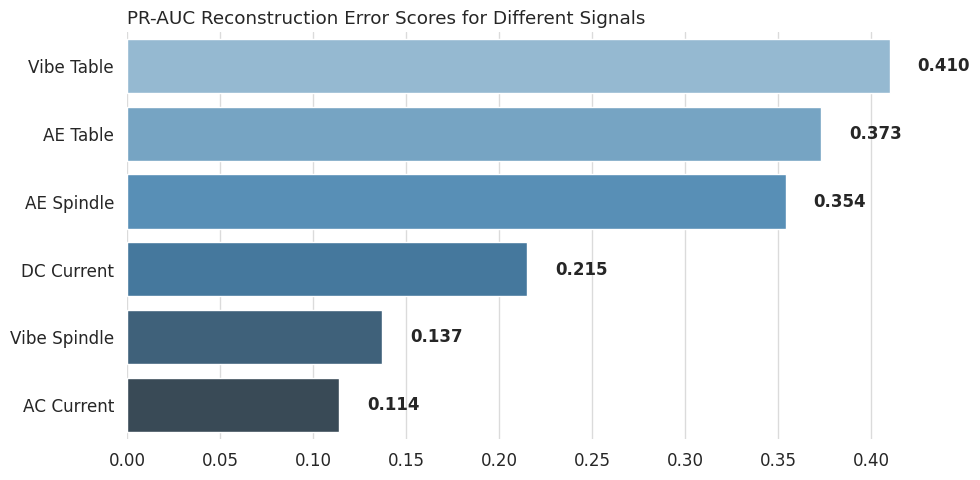

In [54]:
df_all = df_all.sort_values(by="pr_auc_val_score", ascending=False).round(3)

fig, ax = plt.subplots(figsize=(10, 5))

sns.set(font_scale=1.1, style="whitegrid")
ax = sns.barplot(
    x="pr_auc_val_score", y="signal_names", data=df_all, palette="Blues_d", orient="h"
)

# 在條形圖上加上數值標籤
for p in ax.patches:
    space = 0.015
    _x = p.get_x() + p.get_width() + float(space)
    _y = p.get_y() + p.get_height() / 2
    value = f"{p.get_width():.3f}"  # 限制小數位數
    ax.text(_x, _y, value, ha="left", va="center", weight="semibold", size=12)

ax.spines["bottom"].set_visible(True)
ax.set_ylabel("")
ax.set_xlabel("")
ax.grid(alpha=0.7, linewidth=1, axis="x")

plt.title("PR-AUC Reconstruction Error Scores for Different Signals", loc="left")

sns.despine(left=True, bottom=True)

plt.tight_layout()  # 確保圖表完整顯示
plt.show()

## 4.6 Trend MRE and KL-Divergence

Build the mean-reconstruction-error (MRE) trends in the input space, and the KL-Divergence trends in the latent space.

First, we'll do a little exploration to see how the trends look.

3/3 [==============================] - 0s 8ms/step
(183, 6)


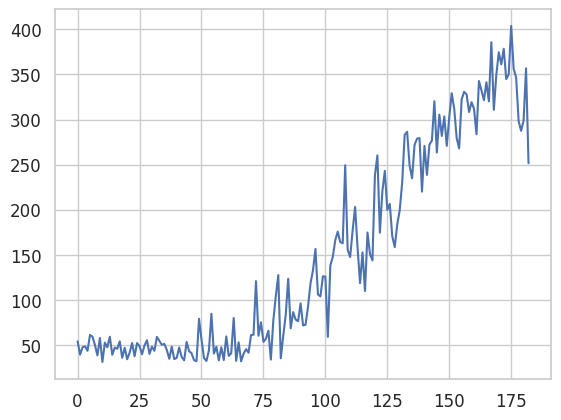

In [58]:
# trend signal 13 in the input space
X_sort, y_sort = sorted_x(X, dfy_val, 13)

mre_all, mre_avg = build_mre_scores(beta_vae_model, X_sort)
print(mre_all.shape)

plt.plot(mre_avg)
plt.show()

3/3 [==============================] - 0s 5ms/step


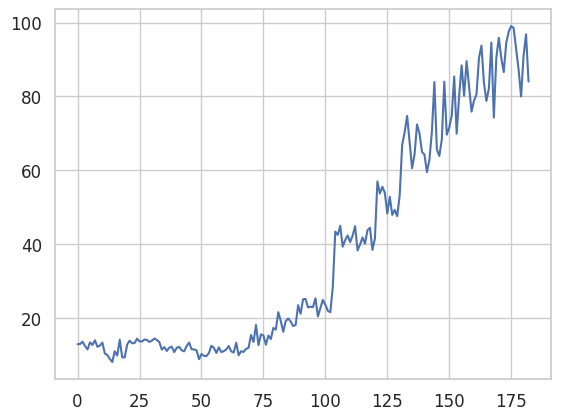

In [61]:
# try the same, as above, but in the latent space
X_sort, y_sort = sorted_x(X, dfy_val, 13)

kls = build_kls_scores(encoder, X_sort)
plt.plot(kls)
plt.show()

Now we'll build a pretty chart showing the trend. It's a bunch of code...

In [62]:
def plot_one_signal_sequentially(
    mres_all,
    y_sort,
    case_no,
    avg_window_size=10,
    dpi=150,
    opacity_color=0.10,
    opacity_grid=0.10,
    m_avg=True,
    caption="MRE",
    y_label="MRE",
    legend_label="MRE",
    save_name="save.png",
):
    """
    Plot a trend of a signal.
    """

    # plot parameters
    colors = ["#33a02c", "#fdbf6f", "#e31a1c"]  # green, orange, red
    failed_reg = ["Healthy", "Degraded", "Failed"]
    pad_size = 0
    x_min = -pad_size

    # create pallette for color of trend lines
    pal = sns.cubehelix_palette(6, rot=-0.25, light=0.7)

    # the "revised" signal names so it looks good on the chart
    signal_names_revised = [
        "AE Spindle\nMRE",
        "AE Table\nMRE",
        "Vibe Spindle\nMRE",
        "Vibe Table\nMRE",
        "DC Current\nMRE",
        "AC Current\nMRE",
    ]

    tool_class_change_index = np.where(y_sort[:-1] != y_sort[1:])[0]

    tool_class_change_index = tool_class_change_index - avg_window_size
    tool_class_change_index = np.concatenate(
        ([0], tool_class_change_index, [np.shape(y_sort)[0] - avg_window_size + 1])
    )

    indexer = (
        np.arange(2)[None, :]
        + np.arange(np.shape(tool_class_change_index)[0] - 1)[:, None]
    )

    # establish shaded region
    shade_reg = tool_class_change_index[indexer]

    x_max = len(y_sort) - avg_window_size + pad_size

    # define colour palette and seaborn style for plot
    sns.set(style="white", context="notebook")

    fig, axes = plt.subplots(
        1, 1, dpi=150, figsize=(7, 2.5), sharex=True, constrained_layout=True,
    )

    x = moving_average(mres_all, n=1)
    x2 = moving_average(mres_all, n=avg_window_size)
    y_avg = np.array([i for i in range(len(x2))]) + avg_window_size
    axes.plot(y_avg, x2, linewidth=1.5, alpha=1, color=pal[5], label="Rolling average")
    axes.plot(x, linewidth=0.5, alpha=0.5, color="grey", label=legend_label)
    y_min = np.min(x)
    y_max = np.max(x)
    y_pad = (np.abs(y_min) + np.abs(y_max)) * 0.02

    axes.spines["top"].set_visible(False)
    axes.spines["right"].set_visible(False)
    axes.spines["left"].set_visible(False)
    axes.spines["bottom"].set_visible(True)
    axes.grid(alpha=opacity_grid, linewidth=0.5)
    axes.tick_params(axis="x", labelsize=7.5)
    axes.tick_params(axis="y", labelsize=7.5)
    axes.spines["bottom"].set_linewidth(0.5)

    # colors
    axes.set_ylim(y_min - y_pad, y_max + y_pad)
    axes.set_xlim(x_min, x_max)
    axes.tick_params(axis="y", labelsize=7.5)
    axes.spines["bottom"].set_linewidth(0.5)
    for region in range(len(shade_reg)):

        f = failed_reg[region % 3]
        c = colors[region % 3]
        axes.fill_between(
            x=shade_reg[region],
            y1=y_min - y_pad,
            y2=y_max + y_pad,
            color=c,
            alpha=opacity_color,
            linewidth=0,
            zorder=1,
        )

        # for text
        axes.text(
            x=(
                shade_reg[region][0] + (shade_reg[region][1] - shade_reg[region][0]) / 2
            ),
            y=y_max + y_pad - y_max * 0.1,
            s=f,
            horizontalalignment="center",
            verticalalignment="center",
            size=8.5,
            color=c,
            rotation="horizontal",
            weight="semibold",
            alpha=1,
        )

    # axis label
    axes.set_xlabel("Sample Number", fontsize=7.5)
    axes.set_ylabel(y_label, fontsize=7.5)

    fig.suptitle(caption, fontsize=8.5)
    plt.legend(
        loc="center left", bbox_to_anchor=(0.02, 0.6), fontsize=7.5,
    )
    plt.show()


18/18 [==============================] - 0s 7ms/step


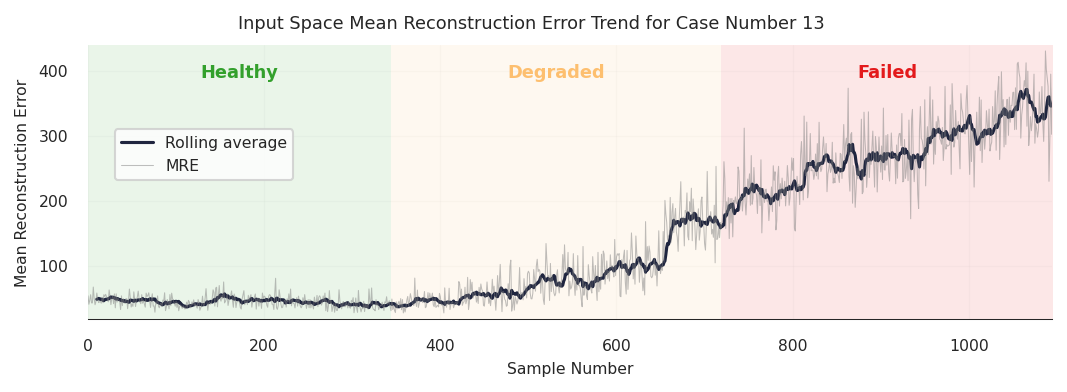

In [63]:
case = 13

caption = "Input Space Mean Reconstruction Error Trend for Case Number {} ".format(case)
legend_label = "MRE"

X_sort, y_sort = sorted_x(X, dfy, case)

mre_all, mre_avg = build_mre_scores(beta_vae_model, X_sort)

plot_one_signal_sequentially(
    mre_avg,
    y_sort,
    case,
    avg_window_size=10,
    opacity_color=0.10,
    opacity_grid=0.10,
    m_avg=True,
    caption=caption,
    y_label="Mean Reconstruction Error",
    legend_label=legend_label,
)

18/18 [==============================] - 0s 4ms/step


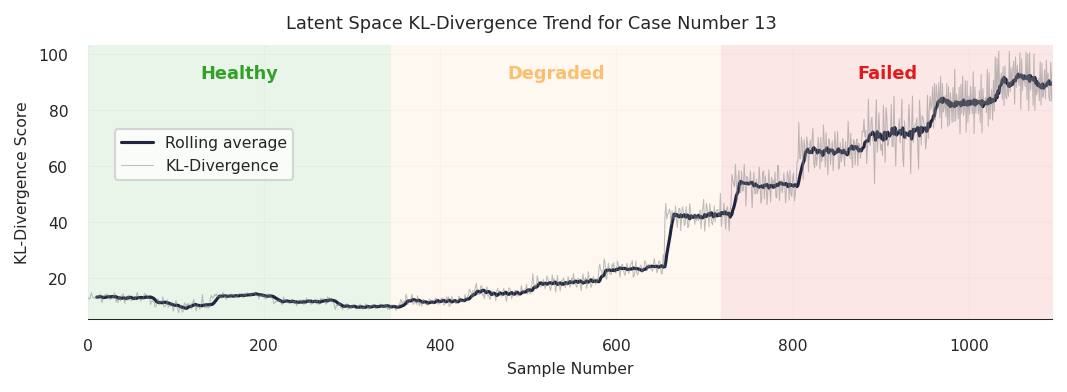

In [64]:
case = 13

caption = "Latent Space KL-Divergence Trend for Case Number {} ".format(case)
legend_label = "KL-Divergence"

X_sort, y_sort = sorted_x(X, dfy, case)

kls = build_kls_scores(encoder, X_sort)

plot_one_signal_sequentially(
    kls,
    y_sort,
    case,
    avg_window_size=10,
    opacity_color=0.10,
    opacity_grid=0.10,
    m_avg=True,
    caption=caption,
    y_label="KL-Divergence Score",
    legend_label=legend_label,
)

Now we'll plot all the input space trends for a single case.

In [65]:
def plot_all_signals_sequentially(
    mres_all,
    y_sort,
    caption,
    avg_window_size=10,
    dpi=150,
    opacity_color=0.10,
    opacity_grid=0.10,
    m_avg=True,
    save_name="save-name",
):
    # plot parameters
    colors = ["#33a02c", "#fdbf6f", "#e31a1c"]  # green, orange, red
    failed_reg = ["Healthy", "Degraded", "Failed"]
    pad_size = 0
    x_min = -pad_size

    # the "revised" signal names so it looks good on the chart
    signal_names_revised = [
        "AE Spindle\nError",
        "AE Table\nError",
        "Vibe Spindle\n Error",
        "Vibe Table\nError",
        "DC Current\nError",
        "AC Current\nError",
    ]

    tool_class_change_index = np.where(y_sort[:-1] != y_sort[1:])[0]
    if m_avg == True:
        tool_class_change_index = tool_class_change_index - avg_window_size
        tool_class_change_index = np.concatenate(
            ([0], tool_class_change_index, [np.shape(y_sort)[0] - avg_window_size + 1])
        )
        indexer = (
            np.arange(2)[None, :]
            + np.arange(np.shape(tool_class_change_index)[0] - 1)[:, None]
        )
        shade_reg = tool_class_change_index[indexer]
        #         print(shade_reg)

        x_max = len(y_sort) - avg_window_size + pad_size

    #         print(indexer)
    #         print(tool_class_change_index[indexer])

    else:
        # find the indices to create the shaded regions
        tool_class_change_index = np.concatenate(
            ([0], tool_class_change_index, [np.shape(y_sort)[0] - 1])
        )
    #         print(tool_class_change_index)

    # define colour palette and seaborn style
    pal = sns.cubehelix_palette(6, rot=-0.25, light=0.7)
    sns.set(style="white", context="notebook")

    fig, axes = plt.subplots(
        6, 1, dpi=150, figsize=(5, 6), sharex=True, constrained_layout=True,
    )

    # go through each of the signals
    for i in range(6):

        if m_avg == True:
            x = moving_average(mres_all[:, i], n=avg_window_size)
            axes[i].plot(x, color=pal[i], linewidth=1, alpha=1)
            y_min = np.min(x)
            y_max = np.max(x)
            y_pad = (np.abs(y_min) + np.abs(y_max)) * 0.05

        else:
            axes[i].plot(mres_all[:, i], color=pal[i], linewidth=1, alpha=1)
            y_min = np.min(mres_all[:, i])
            y_max = np.max(mres_all[:, i])

        axis_label = signal_names_revised[i]
        axes[i].set_ylabel(axis_label, fontsize=6)

        if i != 5:
            axes[i].spines["top"].set_visible(False)
            axes[i].spines["right"].set_visible(False)
            axes[i].spines["left"].set_visible(False)
            axes[i].spines["bottom"].set_visible(True)
            axes[i].grid(alpha=opacity_grid, linewidth=0.5)
            axes[i].set_ylim(y_min - y_pad, y_max + y_pad)
            axes[i].set_xlim(x_min, x_max)
            axes[i].tick_params(axis="y", labelsize=6)
            axes[i].spines["bottom"].set_linewidth(0.5)

            for region in range(len(shade_reg)):
                c = colors[region % 3]
                f = failed_reg[region % 3]
                axes[i].fill_between(
                    x=shade_reg[region],
                    y1=y_min - y_pad,
                    y2=y_max + y_pad,
                    color=c,
                    alpha=opacity_color,
                    linewidth=0,
                    zorder=1,
                )

                # for text
                if i == 0:
                    axes[0].text(
                        x=(
                            shade_reg[region][0]
                            + (shade_reg[region][1] - shade_reg[region][0]) / 2
                        ),
                        y=y_max + y_pad - y_max * 0.10,
                        s=f,
                        horizontalalignment="center",
                        verticalalignment="center",
                        size=6,
                        color=c,
                        rotation="horizontal",
                        weight="semibold",
                        alpha=0.8,
                    )

        else:
            axes[i].spines["top"].set_visible(False)
            axes[i].spines["right"].set_visible(False)
            axes[i].spines["left"].set_visible(False)
            axes[i].spines["bottom"].set_visible(True)
            axes[i].grid(alpha=opacity_grid, linewidth=0.5)
            axes[i].tick_params(axis="x", labelsize=6)
            axes[i].tick_params(axis="y", labelsize=6)
            axes[i].spines["bottom"].set_linewidth(0.5)

            # colors
            axes[i].set_ylim(y_min - y_pad, y_max + y_pad)
            axes[i].set_xlim(x_min, x_max)
            axes[i].tick_params(axis="y", labelsize=6)
            axes[i].spines["bottom"].set_linewidth(0.5)

            for region in range(len(shade_reg)):
                c = colors[region % 3]
                axes[i].fill_between(
                    x=shade_reg[region],
                    y1=y_min - y_pad,
                    y2=y_max + y_pad,
                    color=c,
                    alpha=opacity_color,
                    linewidth=0,
                    zorder=1,
                )

            # axis label
            axes[i].set_xlabel("Sample Number", fontsize=6)

        fig.suptitle(caption, fontsize=7.75, x=0.56, y=1.02, ha="center")

    plt.show()

10/10 [==============================] - 0s 11ms/step


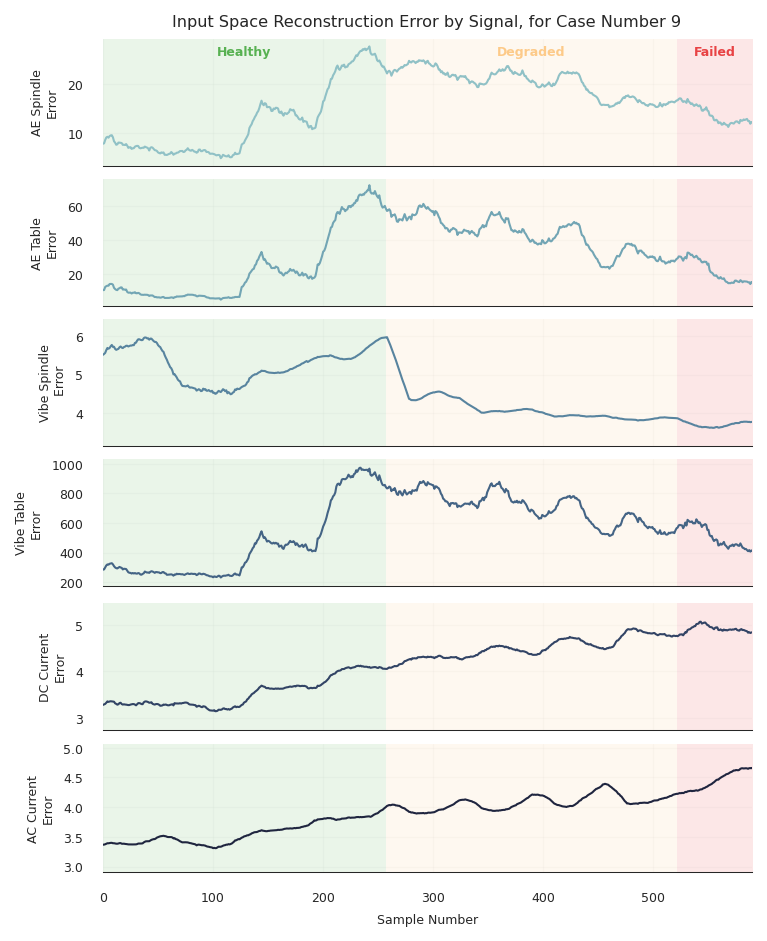

In [66]:
case = 9

caption = "Input Space Reconstruction Error by Signal, for Case Number {} ".format(case)


X_sort, y_sort = sorted_x(X, dfy, case)

mre_all, mre_avg = build_mre_scores(beta_vae_model, X_sort)

plot_all_signals_sequentially(
    mre_all,
    y_sort,
    caption,
    avg_window_size=20,
    opacity_color=0.10,
    opacity_grid=0.10,
    m_avg=True,
)